In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB,GaussianNB


In [4]:
df_path='PS_20174392719_1491204439457_log.csv'

In [5]:
df_raw=pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [6]:
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df_raw.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
df_raw['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [9]:
df=df_raw
df['type']=pd.Categorical(df['type'])
df['type']=df['type'].cat.codes

In [10]:
df['type'].unique()

array([3, 4, 1, 2, 0], dtype=int8)

<AxesSubplot:>

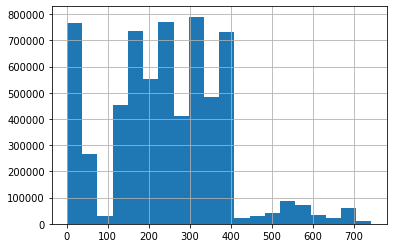

In [11]:
df['step'].hist(bins=20)

In [12]:
df['step']=df.step%24

In [13]:
df.step.describe()

count    6.362620e+06
mean     1.532145e+01
std      4.321799e+00
min      0.000000e+00
25%      1.200000e+01
50%      1.600000e+01
75%      1.900000e+01
max      2.300000e+01
Name: step, dtype: float64

Text(0.5, 0, 'hour')

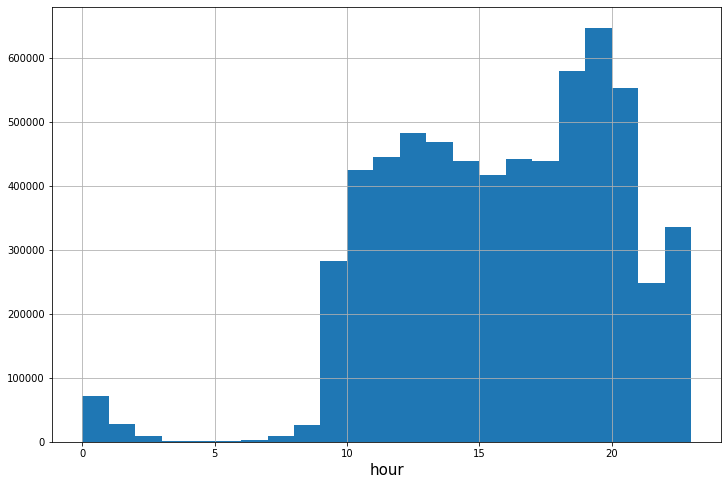

In [14]:
plt.figure(figsize=(12,8))
df.step.hist(bins=np.arange(24))
plt.xlabel('hour',fontsize=15)

As showed below the dataset is unbalenced. So, indor the overcame this, It was randomly selected the same amount of commum trasactions. Then, it was selected a 50-50 ratio. 


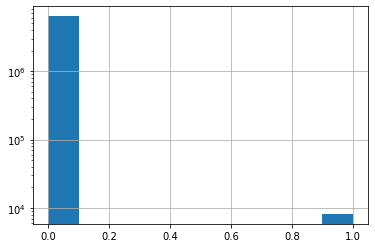

In [15]:
df['isFraud'].hist()
plt.yscale('log')

In [16]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [17]:
len(df)

6362620

In [18]:
len_fraud=len(df[df['isFraud']==1])
index_fraud=np.random.choice(df[df['isFraud']==0].index,len_fraud)


In [19]:
index_fraud.shape

(8213,)

In [20]:
filter_balance_data=(df['isFraud']==1)|(df.index.isin(index_fraud))

In [21]:
df=df[filter_balance_data]

In [22]:
len(df.nameOrig.unique())/len(df)

1.0

In [23]:
len(df.nameDest.unique())/len(df)

0.9890390938984289

This indicates that there will have no gain using origin id on ML models. On otherhand, it may be interesting to use the destionation ID. 

In [24]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,4,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,1,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,4,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,1,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
270,1,1,280877.92,C1544614339,2188.97,0.0,C1297685781,462914.23,16997.22,0,0


In [25]:
df['balance_delta_origin']=(df['newbalanceOrig']-df['oldbalanceOrg'])/df.oldbalanceOrg

c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
df['balance_delta_destination']=(df['newbalanceDest']-df['oldbalanceDest'])/df.oldbalanceDest

c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
df[['balance_delta_destination','balance_delta_origin']]=df[['balance_delta_destination','balance_delta_origin']].fillna(0)

c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [28]:
df[['balance_delta_destination','balance_delta_origin']].describe()

,balance_delta_destination,balance_delta_origin
count,1.642200e+04,16422.0
mean,inf,inf
std,NaN,NaN
min,-1.000000e+00,-1.0
25%,0.000000e+00,-1.0
50%,0.000000e+00,-1.0
75%,7.052269e-01,0.0
max,inf,inf


In [29]:
df[['balance_delta_destination','balance_delta_origin']]=df[['balance_delta_destination','balance_delta_origin']].replace(np.inf,1)

c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [30]:
df[['balance_delta_destination','balance_delta_origin']].describe()

,balance_delta_destination,balance_delta_origin
count,16422.000000,16422.000000
mean,18.333474,7.355918
std,1083.114103,521.207349
min,-1.000000,-1.000000
25%,0.000000,-1.000000
50%,0.000000,-1.000000
75%,0.705227,0.000000
max,103325.518519,66147.963333


In [31]:

def Scale_data(df,column):
    Scaler=StandardScaler()    
    df[column]=Scaler.fit_transform(df[column].values.reshape(-1,1))
    

In [32]:
Scale_data(df,'amount')

c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_delta_origin,balance_delta_destination
2,1,4,-0.445004,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,-1.0,0.000000
3,1,1,-0.445004,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0,-1.0,-1.000000
251,1,4,-0.443589,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0,-1.0,0.000000
252,1,1,-0.443589,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0,-1.0,-1.000000
270,1,1,-0.293684,C1544614339,2188.97,0.0,C1297685781,462914.23,16997.22,0,0,-1.0,-0.963282


In [34]:
X_columns=['type','step','amount','balance_delta_origin','balance_delta_destination']
Y_columns=['isFraud']

In [35]:
X=df[X_columns]
Y=df[Y_columns]

In [36]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.3,stratify=Y)


In [37]:
Xtest,Xval,Ytest,Yval=train_test_split(Xtest,Ytest,test_size=0.5,stratify=Ytest)

## Machine learning

In [38]:
np.random.seed(12345)

In [38]:
DummyModel=DummyClassifier()
DummyModel.fit(Xtrain,Ytrain)
DummyModel.score(Xtest,Ytest)


0.5002030044660982

In [39]:
RandomForest=RandomForestClassifier()
RandomForest.fit(Xtrain,Ytrain)
RF_prediction=RandomForest.predict(Xtest)
accuracy_score(RF_prediction,Ytest)

c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9285424279334146

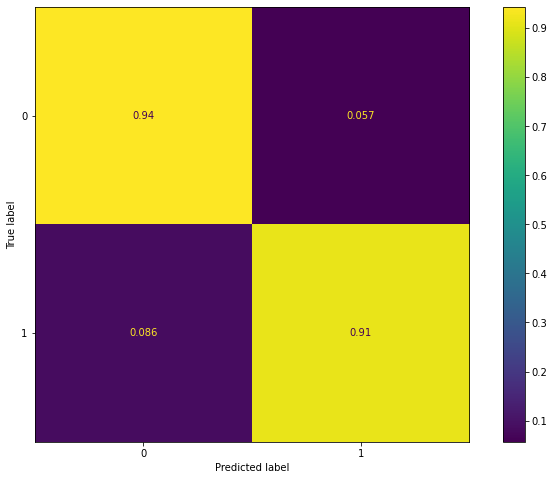

In [40]:
RF_CM=confusion_matrix(Ytest,RF_prediction,normalize='true')
fig,ax=plt.subplots(1,1,figsize=(12,8))
ConfusionMatrixDisplay(confusion_matrix=RF_CM,display_labels=RandomForest.classes_).plot(ax=ax)

In [41]:
Xscaler=StandardScaler()
XtrainScaled=Xscaler.fit_transform(Xtrain)
XtestScaled=Xscaler.transform(Xtest)
# Yscaler=StandardScaler()
# YtrainScaled=Yscaler.fit_transform(Ytrain)
# YtestScaled=Yscaler.transform(Ytest)


In [42]:
SVC_model=SVC()
SVC_model.fit(Xtrain,Ytrain)
SVC_model.score(Xtest,Ytest)

c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6780349167681688

In [43]:
SVC_model=SVC()
SVC_model.fit(XtrainScaled,Ytrain)
SVC_prediction=SVC_model.predict(XtestScaled)
accuracy_score(SVC_prediction,Ytest)

c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8647990255785627

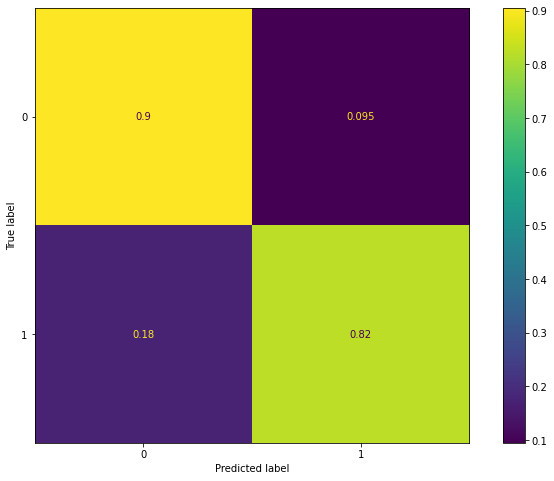

In [44]:
SVC_CM=confusion_matrix(Ytest,SVC_prediction,normalize='true')
fig,ax=plt.subplots(1,1,figsize=(12,8))
ConfusionMatrixDisplay(confusion_matrix=SVC_CM).plot(ax=ax)

In [45]:
# MNB_model=MultinomialNB()
# MNB_model.fit(Xtrain,Ytrain)
# MNB_prediction=MNB_model.predict(XtestScaled)
# accuracy_score(MNB_prediction,Ytest)
# ValueError: Negative values in data passed to MultinomialNB (input X):

In [46]:
GNB_model=GaussianNB()
GNB_model.fit(Xtrain,Ytrain)
GNB_prediction=GNB_model.predict(Xtest)
accuracy_score(GNB_prediction,Ytest)

c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8591149005278116

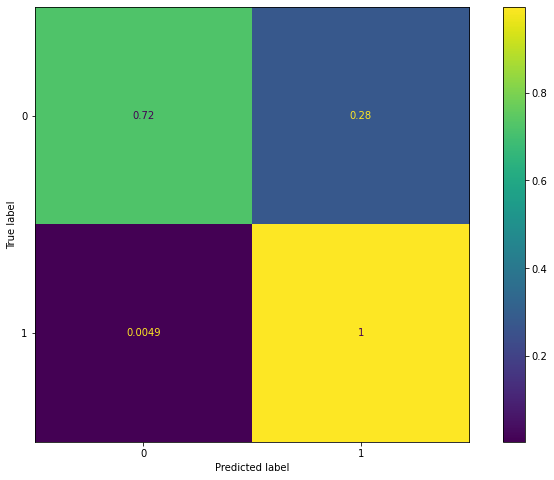

In [47]:
GNB_CM=confusion_matrix(Ytest,GNB_prediction,normalize='true')
fig,ax=plt.subplots(1,1,figsize=(12,8))
ConfusionMatrixDisplay(confusion_matrix=GNB_CM).plot(ax=ax)

### Finetunnnig RandomForest

RandomSearchCV

In [49]:
RandomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [56]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_leaf =[10,100,1000]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [10, 100, 1000],
 'bootstrap': [True, False]}

In [57]:
RF=RandomForestClassifier()
RF_random=RandomizedSearchCV(estimator=RF,param_distributions=random_grid,n_iter=100,cv=5,verbose=2,n_jobs=-1)
RF_random.fit(Xtrain,Ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [10, 100, 1000],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [64]:
RF_best=RF_random.best_estimator_
RF_best.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [65]:
RF_best_prediction=RF_best.predict(Xtest)
accuracy_score(RF_best_prediction,Ytest)

0.928948436865611

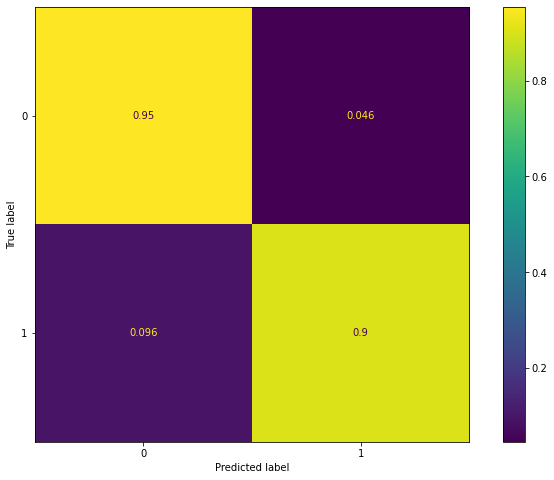

In [66]:
RF_best_CM=confusion_matrix(Ytest,RF_best_prediction,normalize='true')
fig,ax=plt.subplots(1,1,figsize=(12,8))
ConfusionMatrixDisplay(confusion_matrix=RF_best_CM,display_labels=RF_best.classes_).plot(ax=ax)

It seems that our improvement wasn't real after all, since the number of true postivies decreased and the number of false positive increased.


GRID SEARCH

In [3]:
n_estimators = [int(x) for x in np.linspace(start = 1200, stop = 1600, num = 10)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.arange(5, 16)]
min_samples_leaf =range(5,20)
bootstrap = [False]

param_grid={'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap
            }

In [45]:
RF=RandomForestClassifier()
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(Xtrain,Ytrain)

                        

Fitting 3 folds for each of 1650 candidates, totalling 4950 fits


c:\Users\estevan.amazonas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': range(5, 20),
                         'n_estimators': [1200, 1244, 1288, 1333, 1377, 1422,
                                          1466, 1511, 1555, 1600]},
             verbose=2)

In [46]:
grid_search.best_params_


{'bootstrap': False,
 'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'n_estimators': 1288}

In [47]:
RF_best_GS=grid_search.best_estimator_

In [49]:
RF_best_GS_predictions=RF_best_GS.predict(Xtest)
accuracy_score(Ytest,RF_best_GS_predictions)

0.9293544457978076

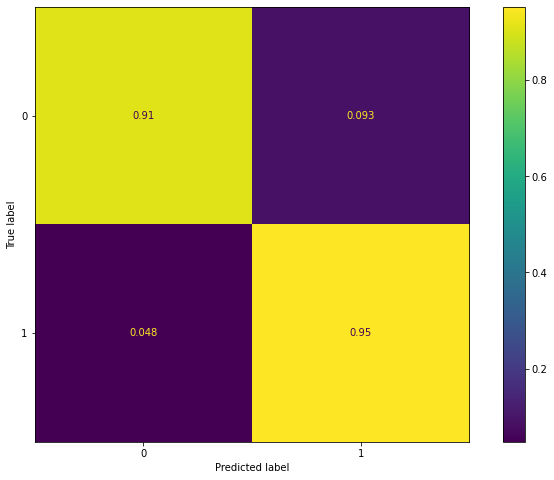

In [50]:
RF_best_GS_CM=confusion_matrix(Ytest,RF_best_GS_predictions,normalize='true')
fig,ax=plt.subplots(1,1,figsize=(12,8))
ConfusionMatrixDisplay(confusion_matrix=RF_best_GS_CM,display_labels=RF_best_GS.classes_).plot(ax=ax)